In [1]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import scipy 
from scipy.integrate import trapz,simps

from colossus.cosmology import cosmology

In [2]:
def model(Om,b2,beta,k,z=0.57):
    cosmo = cosmology.setCosmology('planck15',)
    cosmo.Om0 = Om
    return (1-beta)*b2**2*cosmo.matterPowerSpectrum(k,z) #función

In [3]:
#Funcion para calcular la chi cuadrada 
def chisq_2(theta,data):
    om, b2, beta = theta
    #Nuestros datos
    x, y, yerr = data
    sigma2 = yerr**2 
    #Sumamos para encontrar el logaritmo del likelihood
    return -0.5*np.sum((y-model(om,b2,beta,x,z=0.57))**2/sigma2 + np.log(sigma2))

In [4]:
# Prior
def log_prior(theta):
    om, b2, beta = theta
    if 0.05 < om < 1.0 and 0.05 < b2 < 5.0 and 0.001 < beta < 1.0:
        return 0.0
    return -np.inf

In [5]:
def metrop_2(om_ini,b_ini,beta_ini,data,sigm,ite):
    np.random.seed(1)
    #Reordenamos el arreglo de a y b iniciales.
    om_ini = om_ini.T.reshape((len(om_ini),1))
    b_ini = b_ini.T.reshape((len(b_ini),1))
    beta_ini = beta_ini.T.reshape((len(beta_ini),1))
    data = np.array(data)
    
    ch_ini = [] #iniciamos lista para los valores de chi iniciales.
    
    #Llenamos chi_ini con los valores iniciales 
    for i in range(len(om_ini)):
        ch_ini.append(chisq_2([om_ini[i][0],b_ini[i][0],beta_ini[i][0]],data)+ log_prior([om_ini[i][0],b_ini[i][0],beta_ini[i][0]])) #prior
    
    #Transformamos a_ini de array a list para usar la función append.
    om = om_ini.tolist()
    b = b_ini.tolist()
    beta = beta_ini.tolist()
    
    for i in range(len(om_ini)):
        ch_0 = ch_ini[i] 
        k = 0
        for j in range(ite): 
            om_af = np.random.normal(om[i][k],sigm) #creamos un valor de a y b aleatorios
            b_af = np.random.normal(b[i][k],sigm) #calculamos el logaritmo del likelihood de para los parametros aleatorios
            beta_af = np.random.normal(beta[i][k],sigm) 
            
            lg = log_prior([om_af,b_af,beta_af])
            
            if lg != 0:
                ch = lg
            else:
                ch = chisq_2([om_af,b_af,beta_af],data) + lg
            
            if ch > ch_0: #Comparamos las dos dos logaritmos 
                om[i].append(om_af) #guardamos los parametros creados 
                b[i].append(b_af)
                beta[i].append(beta_af)
                k = k+1
                ch_0 = ch # si el nuevo logaritmo es es mayor que el anterior lo tomamos como el nuevo
            else:
                r = np.log(np.random.uniform(0,1)) 
                diff = ch-ch_0
                if diff > r: #Si la diferencia entre los logaritmos (anterior y nuevo) es menor al dicho valor
                    om[i].append(om_af)
                    b[i].append(b_af)
                    beta[i].append(beta_af)
                    k = k+1
                    ch_0 = ch #Tomamos el nuevo logaritmo
                else:  #si la direfencia es mayor, sólo guardamos los valores de a y b creados
                    om[i].append(om[i][k]) 
                    b[i].append(b[i][k])
                    beta[i].append(beta[i][k])
                    k = k+1
            

    # Parte de grafico
    plt.figure(figsize=(8,6))    
    
    #Gráfica de todos los puntos
    for i in range(len(om_ini)):     
        plt.scatter(om[i],b[i],s=1)
    plt.ylabel('b',fontsize=18)
    plt.xlabel('$\Omega_m$',fontsize=18)
    plt.title("Varios Caminadores",fontsize=18)
    return  om, b, beta

In [6]:
#Función para solo tomar el cumulo de los caminadores y graficarlos con sus histograma
def flags_data_1(a,b,beta,flags):
    a_flg = np.array([])
    b_flg = np.array([])
    beta_flg = np.array([])
    for i in range(len(a)): 
        a_flg = np.append(a_flg,a[i][flags:]) #Solo tomamos los valores de los parametros por arriba del número flags 
        b_flg = np.append(b_flg,b[i][flags:])
        beta_flg = np.append(beta_flg,beta[i][flags:])
    
    flgs = np.array([a_flg,b_flg,beta_flg])
    n = len(flgs)
    m = []
    mp = []
    titulo = ['Histograma de $\Omega_m$', 'Histograma de b','Histograma de $beta$']
    
    #Sección para graficar:
    plt.figure(figsize=(10,10))  
    for i in range(n):
        for j in range(i+1):
            k = i-j
            if i == k:
                plt.subplot(n,n,((i*n)+k+1))
                hist = plt.hist(flgs[k], bins=20,facecolor='grey',alpha = 0.8)
                m.append(np.mean(hist[1]))
                mp.append(np.mean(hist[1]))
                plt.axvline(m[i],color='r',label = np.round(m[i],4))
                plt.title(titulo[i],fontsize=18)
                plt.legend();
            else:
                plt.subplot(n,n,((i*n)+k+1))
                plt.hexbin(flgs[k], flgs[i], gridsize=30, cmap='Greys')
                plt.axvline(m[k],color='r',label = np.round(m[k],4))
                plt.axhline(m[i],color='b',label = np.round(m[i],4))
                plt.legend();
    
    return a_flg , b_flg, beta_flg, m

#### Mostramos los datos

(100, 300000.0)

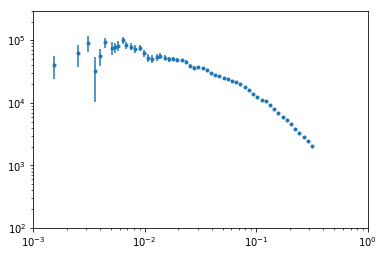

In [7]:
pk_cmasdr12 = np.loadtxt('GilMarin_boss_data/post-recon/cmass/GilMarin_2016_CMASSDR12_measurement_monopole_post_recon.txt').T

plt.figure()
plt.loglog()
plt.errorbar(pk_cmasdr12[0],pk_cmasdr12[1],yerr=pk_cmasdr12[2],fmt='.')
plt.xlim(1e-3,1)
plt.ylim(100,3e5)

#### Eliminamos los primeros y ultimos puntos

(1500, 300000.0)

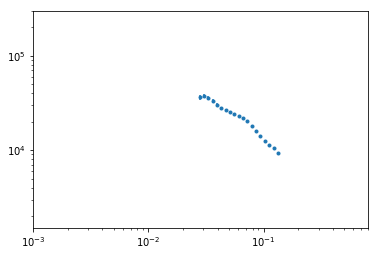

In [11]:
li = 26
ls = len(pk_cmasdr12[0])-10
k, pk, pk_err = pk_cmasdr12[0][li:ls],pk_cmasdr12[1][li:ls],pk_cmasdr12[2][li:ls]

plt.figure()
plt.loglog()
plt.errorbar(k,pk,yerr = pk_err,fmt='.')
plt.xlim(1e-3,0.8)
plt.ylim(1500,3e5)

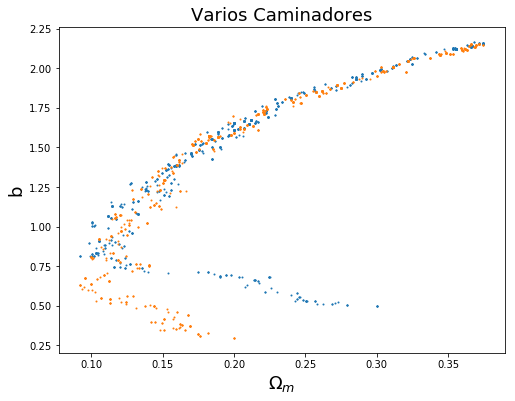

In [13]:
cosmo = cosmology.setCosmology('planck15',)

data = [k,pk,pk_err]

sigma = 0.01
om_ini = np.array([0.3,0.2])
b_ini = np.array([0.5,0.3])
beta_ini = np.array([0.5,0.1])
ite = 1000

om_2,b_2,beta_2= metrop_2(om_ini,b_ini,beta_ini,data,sigma,ite)

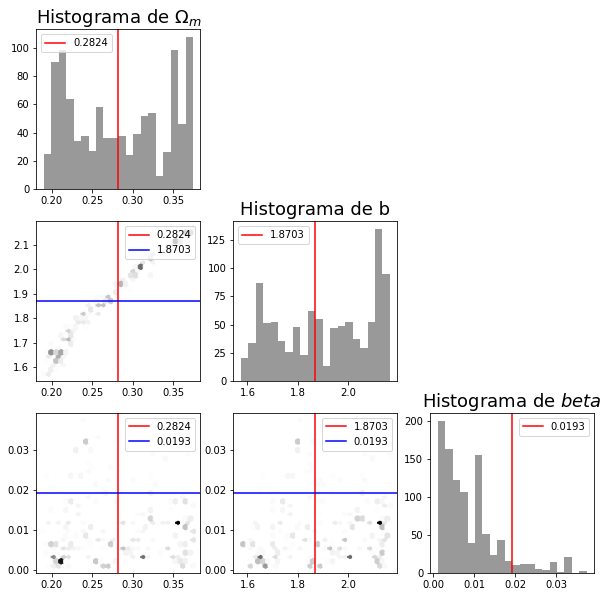

In [18]:
flags = 500
omg_flg,b_flg,beta_flg, m = flags_data_1(om_2,b_2,beta_2,flags)

(1500, 300000.0)

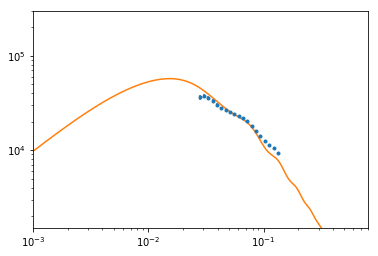

In [19]:
k_m = 10**np.linspace(-6,5,100000)
pk_m = model(m[0],m[1],m[2],k_m,z=0.57)

plt.figure()
plt.loglog()
plt.errorbar(k,pk,yerr = pk_err,fmt='.')
plt.plot(k_m,pk_m,'-')
plt.xlim(1e-3,0.8)
plt.ylim(1500,3e5)

Checa la Página Tutorial:
https://bdiemer.bitbucket.io/colossus/_static/tutorial_cosmology.html

In [113]:
cosmo = cosmology.setCosmology('planck15',) #Se seleccionan el tranajo de planck
print(cosmo)

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [114]:
#Cambiamos los parametros para seleccionar la cosmologia
cosmo.Om0 = 0.29
cosmo.Omde = 0.71
cosmo.ns = 0.97
cosmo.H0 = 70
cosmo.relspecies  = False
cosmo.checkForChangedCosmology()
print(cosmo)

Cosmology: Detected change in cosmological parameters.
Cosmology "planck15" 
    flat = True, Om0 = 0.2900, Ode0 = 0.7100, Ob0 = 0.0486, H0 = 70.00, sigma8 = 0.8159, ns = 0.9700
    de_model = lambda, relspecies = False, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


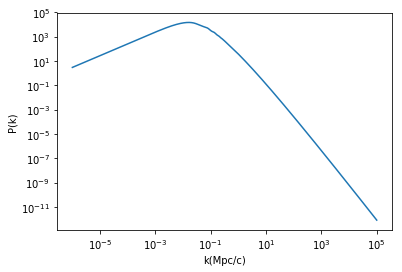

In [115]:
k = 10**np.linspace(-6,5,100000)
Pk = cosmo.matterPowerSpectrum(k,0.57) #Redshft = 0.57

plt.figure()
plt.loglog()
plt.xlabel('k(Mpc/c)')
plt.ylabel('P(k)')
plt.plot(k,Pk)

Para descargar datos: http://www.sdss3.org/science/boss_publications.php

(100, 300000.0)

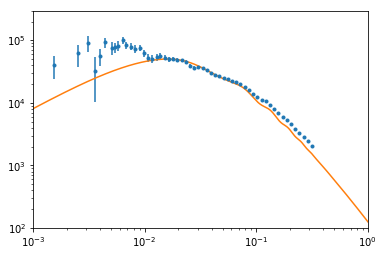

In [116]:
pk_cmasdr12 = np.loadtxt('GilMarin_boss_data/post-recon/cmass/GilMarin_2016_CMASSDR12_measurement_monopole_post_recon.txt').T

plt.figure()
plt.loglog()
plt.errorbar(pk_cmasdr12[0],pk_cmasdr12[1],yerr=pk_cmasdr12[2],fmt='.')
plt.plot(k,1.85**2*Pk,'-')
plt.xlim(1e-3,1)
plt.ylim(100,3e5)

In [59]:
cosmo = cosmology.setCosmology('planck15',) #Se inicia la clase de nuevo
print(cosmo)

def Pk_Om(Om,b2,k,z=0.57):
    cosmo.Om0 = Om
    return b2**2*cosmo.matterPowerSpectrum(k,z) #función

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


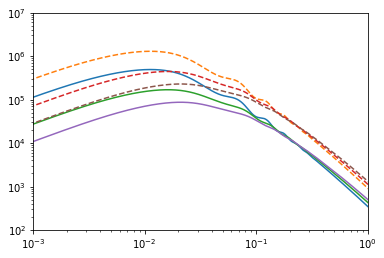

In [61]:
plt.figure()
plt.loglog()
#plt.errorbar(pk_cmasdr12[0],pk_cmasdr12[1],yerr=pk_cmasdr12[2],fmt='.')
OM = (0.2,0.3,0.4)
for om in OM:
    plt.plot(k,1.85**2*Pk_Om(om,1.85,k),'-')
    plt.plot(k,1.85**2*Pk_Om(om,3,k),'--')
    plt.xlim(1e-3,1)
    plt.ylim(100,1e7)